# MLHC Training Pipeline

Objective: build features, train models, evaluate performance, and persist artifacts for mortality, prolonged LOS, and readmission.

## Workflow
1. Configure environment & paths
2. Connect to data source (DuckDB or BigQuery equivalent)
3. Extract cohort + modalities (first admissions + 48h windows)
4. Build raw features and prune
5. Train models (mortality, prolonged LOS, readmission)
6. Calibrate (optional) and persist artifacts
7. Evaluate metrics and inspect distributions



In [1]:
# Environment & core imports
import os, sys, json, random, platform, importlib, datetime, pathlib
from pathlib import Path
import numpy as np, pandas as pd

# Add project root to path if notebook is under notebooks/
ROOT = pathlib.Path(__file__).resolve().parents[1] if '__file__' in globals() else pathlib.Path.cwd().parents[0]
if str(ROOT) not in sys.path: sys.path.insert(0, str(ROOT))


SEED = 42
random.seed(SEED); np.random.seed(SEED)
PROJECT_ROOT = (Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd())
DATA_DIR = PROJECT_ROOT / 'data'
ARTIFACTS_DIR = PROJECT_ROOT / 'project/artifacts'
RUNS_ROOT = PROJECT_ROOT / 'runs'
print(f"Project root: {PROJECT_ROOT}")
print(f"Data dir exists: {(DATA_DIR).exists()}")
VERSIONS = {'python': sys.version.split()[0], 'platform': platform.platform()}
for pkg in ['xgboost','optuna','shap','sklearn','pandas','numpy']:
    try:
        m = importlib.import_module(pkg if pkg != 'sklearn' else 'sklearn')
        VERSIONS[pkg] = getattr(m,'__version__','?')
    except Exception as e:
        VERSIONS[pkg] = f'NA({e})'
print('Versions:', json.dumps(VERSIONS, indent=2))

Project root: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project
Data dir exists: True
Versions: {
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}
Versions: {
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}


## 1. Environment Setup
Configure base paths and basic dependencies.

In [2]:
# Load canonical labels produced by duckdb_extraction notebook
import pandas as pd, random
from pathlib import Path

# Force single authoritative path (output of duckdb_extraction)
LABELS_PATH = (PROJECT_ROOT / 'project' / 'artifacts' / 'labels.csv')
if not LABELS_PATH.exists():
    raise FileNotFoundError(f'Expected labels at {LABELS_PATH}. Run duckdb_extraction notebook first to generate labels.csv there.')

labels_df = pd.read_csv(LABELS_PATH)
# Normalize required columns
required_cols = {'subject_id','hadm_id','readmission_label','mortality_label','prolonged_los_label'}
missing = required_cols - set(labels_df.columns)
if missing:
    raise ValueError(f'Missing expected label columns in {LABELS_PATH}: {missing}')

labels_df = labels_df.drop_duplicates('subject_id')
for col in ['readmission_label','mortality_label','prolonged_los_label']:
    labels_df[col] = labels_df[col].astype(int)
assert labels_df['subject_id'].isna().sum()==0
prev_readmit = labels_df['readmission_label'].mean()
print(f'Labels source: {LABELS_PATH} | shape={labels_df.shape} | readmission_prevalence={prev_readmit:.4f}')

Labels source: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\labels.csv | shape=(28340, 5) | readmission_prevalence=0.0435


## 2. Cohort & Admissions
Extract first admissions and enforce LOS >=54h.

In [3]:
# Load feature matrix (regenerate if tiny/corrupt) + strict safe alignment
import pandas as pd, numpy as np, json, os
from pathlib import Path

feature_path = ARTIFACTS_DIR / 'features_full.parquet'
if not feature_path.exists():
    raise FileNotFoundError(f'Missing feature parquet: {feature_path}')

feature_df = pd.read_parquet(feature_path)
regenerated = False  # placeholder if regeneration logic later added

# Ensure subject_id index
if 'subject_id' in feature_df.columns:
    if feature_df['subject_id'].duplicated().any():
        raise RuntimeError('Duplicate subject_id rows in feature parquet.')
    feature_df = feature_df.set_index('subject_id')

# Canonical integer index (fix KeyError mismatch from mixed string/int earlier)
try:
    feature_df.index = feature_df.index.astype(int)
except Exception as e:
    raise RuntimeError(f'Failed to coerce feature index to int: {e}')
if feature_df.index.has_duplicates:
    raise RuntimeError('Feature index has duplicates after int coercion.')

# Labels already loaded upstream into labels_df
label_subjects = labels_df['subject_id'].astype(int)

feat_ids = feature_df.index
missing_in_features = set(label_subjects) - set(feat_ids)
extra_in_features = set(feat_ids) - set(label_subjects)
overlap_frac = 1 - (len(missing_in_features)/len(label_subjects)) if len(label_subjects) else 0
print(f"[cohort-diff] label_subjects={len(label_subjects)} feature_subjects={len(feat_ids)}")
print(f"[cohort-diff] missing_in_features={len(missing_in_features)} extra_in_features={len(extra_in_features)}")
print(f"[align] overlap_frac={overlap_frac:.4f}")

if missing_in_features:
    raise RuntimeError(f'Missing {len(missing_in_features)} subjects (sample: {list(missing_in_features)[:10]})')

# Pre-alignment variance snapshot (for collapse detection)
pre_var = feature_df.var(numeric_only=True, ddof=0)

# Strict ordering alignment
feature_df_aligned = feature_df.loc[label_subjects.values]

post_var = feature_df_aligned.var(numeric_only=True, ddof=0)
collapsed = [c for c in pre_var.index if pre_var[c] > 0 and post_var[c] == 0]
if collapsed:
    print(f'WARNING: {len(collapsed)} columns lost variance post-alignment (e.g. {collapsed[:5]}).')
else:
    print('[align] Variance preserved.')

print('Features aligned shape:', feature_df_aligned.shape, '| regenerated' if regenerated else '')

# Expose for downstream cells
features_loaded = feature_df_aligned

[cohort-diff] label_subjects=28340 feature_subjects=28340
[cohort-diff] missing_in_features=0 extra_in_features=0
[align] overlap_frac=1.0000
[align] Variance preserved.
Features aligned shape: (28340, 1500) 
[align] Variance preserved.
Features aligned shape: (28340, 1500) 


## 3. Modalities Extraction
Pull demographics, vitals, labs, prescriptions, procedures (0-48h window).

In [6]:
# Train/valid/test split (60/20/20) + class weight factor
from sklearn.model_selection import train_test_split
readmit_y = labels_df['readmission_label'].astype(int).to_numpy()
subject_index = feature_df.index.to_numpy()
X = feature_df.values
X_tr, X_temp, y_tr, y_temp, sid_tr, sid_temp = train_test_split(
    X, readmit_y, subject_index, test_size=0.4, stratify=readmit_y, random_state=SEED)
X_val, X_te, y_val, y_te, sid_val, sid_te = train_test_split(
    X_temp, y_temp, sid_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
pos_rate = y_tr.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
print(f'Split -> train {X_tr.shape} valid {X_val.shape} test {X_te.shape} | pos_rate_train={pos_rate:.4f} | spw≈{scale_pos_weight:.2f}')

Split -> train (17004, 1500) valid (5668, 1500) test (5668, 1500) | pos_rate_train=0.0435 | spw≈22.01


## 4. Feature Engineering
Aggregate time-series stats + counts/missingness; drop leakage columns.

In [7]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import numpy as np
C_FP = 1.0; C_FN = 5.0
beta = 2.0

def metrics_at(proba, y, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = C_FP*fp + C_FN*fn
    f1 = f1_score(y, pred)
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    fbeta = (1+beta**2)*prec*rec/(beta**2*prec+rec+1e-9)
    return dict(f1=f1, precision=prec, recall=rec, cost=cost, fbeta=fbeta)

## 5. Pruning & Schema
Variance/support pruning; capture provenance & persist feature columns.

In [8]:

SEED = 42
rng_global = np.random.default_rng(SEED)

TARGET_SPECS = [
    ('readmission','readmission_label'),
    ('mortality','mortality_label'),
    ('prolonged_los','prolonged_los_label'),
]


# Verify presence of target columns
missing_targets = [lbl for _,lbl in TARGET_SPECS if lbl not in labels_df.columns]
if missing_targets:
    raise ValueError(f"Missing target label columns: {missing_targets}")

# Shared subject index + base split for comparability
subject_index = feature_df.index.to_numpy()
X = feature_df.values
primary_y = labels_df[TARGET_SPECS[0][1]].astype(int).to_numpy()  # stratify on first target
X_tr, X_temp, y_tr_primary, y_temp_primary, sid_tr, sid_temp = train_test_split(X, primary_y, subject_index, test_size=0.4, stratify=primary_y, random_state=SEED)
X_val, X_te, y_val_primary, y_te_primary, sid_val, sid_te = train_test_split(X_temp, y_temp_primary, sid_temp, test_size=0.5, stratify=y_temp_primary, random_state=SEED)
print(f'Shared split shapes -> train {X_tr.shape} val {X_val.shape} test {X_te.shape}')

subj_to_pos = {sid:i for i,sid in enumerate(subject_index)}
idx_tr = np.array([subj_to_pos[s] for s in sid_tr])
idx_val = np.array([subj_to_pos[s] for s in sid_val])
idx_te = np.array([subj_to_pos[s] for s in sid_te])
metrics_all = {}


Shared split shapes -> train (17004, 1500) val (5668, 1500) test (5668, 1500)


## 6. Label Join & Sanity Checks
Align features with labels; assert subject ID match and ordering.

In [9]:
# Multi-target baseline (logistic) for reference per target
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

baseline_results = {}
X_base = X_tr  # using training split from shared split
X_val_base = X_val

for tgt_name, label_col in TARGET_SPECS:
    y_tr_t = labels_df[label_col].astype(int).to_numpy()[idx_tr]
    y_val_t = labels_df[label_col].astype(int).to_numpy()[idx_val]
    pipe = Pipeline([
        ("imp", SimpleImputer(strategy='median')),
        ("sc", StandardScaler(with_mean=False)),
        ("lr", LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
    ])
    pipe.fit(X_base, y_tr_t)
    val_proba = pipe.predict_proba(X_val_base)[:,1]
    auc_val = roc_auc_score(y_val_t, val_proba)
    baseline_results[tgt_name] = float(auc_val)
print('Baseline logistic validation AUCs per target:', baseline_results)

Baseline logistic validation AUCs per target: {'readmission': 0.5874545458619089, 'mortality': 0.7923179508441571, 'prolonged_los': 0.8021399656370639}


## 7. Model Training
Train classifiers for each target with consistent preprocessing.

In [10]:
# Multi-target tuning & training pipeline (updated to persist final_model + artifact paths)
import optuna, numpy as np, json, joblib
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier


# Hyperparameter search configuration
N_TRIALS_PER_TARGET = 15  # increase for better tuning
N_FOLDS = 5
MAX_ROUNDS = 400
SPEED_SAMPLE_MAX = 12000

def make_objective(X_train_full, y_train_full):
    def objective(trial: optuna.Trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 7),
            'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 8.0),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_lambda': trial.suggest_float('lambda', 1e-3, 5.0, log=True),
            'reg_alpha': trial.suggest_float('alpha', 1e-3, 2.0, log=True),
            'gamma': trial.suggest_float('gamma', 0.0, 4.0),
            'n_estimators': trial.suggest_int('n_estimators', 120, MAX_ROUNDS),
        }
        fold_aucs = []
        skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        for fold,(tr_idx_local, va_idx_local) in enumerate(skf.split(X_train_full, y_train_full), 1):
            Xtr_f, Xva_f = X_train_full[tr_idx_local], X_train_full[va_idx_local]
            ytr_f, yva_f = y_train_full[tr_idx_local], y_train_full[va_idx_local]
            if Xtr_f.shape[0] > SPEED_SAMPLE_MAX:
                pos_idx = np.where(ytr_f==1)[0]
                neg_idx = np.where(ytr_f==0)[0]
                keep_pos = pos_idx
                remaining = SPEED_SAMPLE_MAX - len(keep_pos)
                if remaining < len(neg_idx):
                    keep_neg = np.random.default_rng(SEED+fold).choice(neg_idx, size=remaining, replace=False)
                else:
                    keep_neg = neg_idx
                keep = np.concatenate([keep_pos, keep_neg])
                np.random.default_rng(SEED+fold).shuffle(keep)
                Xtr_f = Xtr_f[keep]; ytr_f = ytr_f[keep]
            pos_rate_fold = ytr_f.mean(); spw = (1-pos_rate_fold)/max(pos_rate_fold,1e-6)
            model = XGBClassifier(objective='binary:logistic', tree_method='hist', scale_pos_weight=spw, eval_metric='auc', verbosity=0, **params)
            model.fit(Xtr_f, ytr_f, verbose=False)
            proba = model.predict_proba(Xva_f)[:,1]
            fold_auc = roc_auc_score(yva_f, proba)
            fold_aucs.append(fold_auc)
        mean_auc = float(np.mean(fold_aucs))
        trial.set_user_attr('fold_aucs', fold_aucs)
        trial.set_user_attr('cv_mean_auc', mean_auc)
        return mean_auc
    return objective

for tgt_name, label_col in TARGET_SPECS:
    print('\n==== Target:', tgt_name, '('+label_col+') ====')
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_tr_t = y_all[idx_tr]; y_val_t = y_all[idx_val]; y_te_t = y_all[idx_te]
    pos_rate = y_tr_t.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
    print(f'Pos rate train: {pos_rate:.4f} -> spw {scale_pos_weight:.2f}')
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    objective = make_objective(X_tr, y_tr_t)
    study.optimize(objective, n_trials=N_TRIALS_PER_TARGET, show_progress_bar=False)
    best_params = study.best_params.copy()
    print('Best CV mean AUC:', round(study.best_value,4))
    print('Best Params:', best_params)
    # Final model retrained on train + validation (for potential deployment / ensembling)
    X_tr_full_t = np.vstack([X_tr, X_val])
    y_tr_full_t = np.concatenate([y_tr_t, y_val_t])
    final_model = XGBClassifier(objective='binary:logistic', tree_method='hist', learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_lambda=best_params['lambda'], reg_alpha=best_params['alpha'], gamma=best_params['gamma'], scale_pos_weight=scale_pos_weight, eval_metric='auc', verbosity=0)
    final_model.fit(X_tr_full_t, y_tr_full_t)
    # Calibration base model (train-only) to avoid leaking validation into both model weights and calibrator
    base_model = XGBClassifier(objective='binary:logistic', tree_method='hist', learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], subsample=best_params['subsample'], colsample_bytree=best_params['colsample_bytree'], reg_lambda=best_params['lambda'], reg_alpha=best_params['alpha'], gamma=best_params['gamma'], scale_pos_weight=scale_pos_weight, eval_metric='logloss', verbosity=0)
    base_model.fit(X_tr, y_tr_t)
    val_raw = base_model.predict_proba(X_val)[:,1]
    iso = IsotonicRegression(out_of_bounds='clip'); iso.fit(val_raw, y_val_t)
    val_cal = iso.transform(val_raw)
    # Threshold selection on calibrated validation probabilities (maximize F1)
    ths = np.linspace(0.01,0.9,300)
    best_thr = None; best_f1 = -1; best_val_metrics = None
    def _metrics_at(proba, y, thr):
        pred = (proba >= thr).astype(int)
        tp = ((pred==1)&(y==1)).sum(); fp = ((pred==1)&(y==0)).sum(); fn = ((pred==0)&(y==1)).sum()
        prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
        f1 = 2*prec*rec/(prec+rec+1e-9)
        return dict(precision=float(prec), recall=float(rec), f1=float(f1))
    for t in ths:
        m = _metrics_at(val_cal, y_val_t, t)
        if m['f1'] > best_f1:
            best_f1 = m['f1']; best_thr = float(t); best_val_metrics = m
    print('Selected threshold (validation calibrated):', best_thr, best_val_metrics)
    # Test evaluation using calibrated base model
    test_cal = iso.transform(base_model.predict_proba(X_te)[:,1])
    auc = roc_auc_score(y_te_t, test_cal)
    pr_auc = average_precision_score(y_te_t, test_cal)
    brier = brier_score_loss(y_te_t, test_cal)
    test_pred = (test_cal >= best_thr).astype(int)
    tp = ((test_pred==1)&(y_te_t==1)).sum(); fp = ((test_pred==1)&(y_te_t==0)).sum(); fn = ((test_pred==0)&(y_te_t==1)).sum()
    prec_test = tp/(tp+fp+1e-9); rec_test = tp/(tp+fn+1e-9)
    f1_test = 2*prec_test*rec_test/(prec_test+rec_test+1e-9)
    metrics = {'auc': float(auc), 'pr_auc': float(pr_auc), 'brier': float(brier), 'threshold': best_thr, 'f1_at_threshold': float(f1_test), 'precision_at_threshold': float(prec_test), 'recall_at_threshold': float(rec_test), 'validation_threshold_info': {**best_val_metrics, 'threshold': best_thr}, 'optuna_best_value_cv_mean_auc': float(study.best_value), 'optuna_best_params': best_params, 'train_rows': int(X_tr.shape[0]), 'val_rows': int(X_val.shape[0]), 'test_rows': int(X_te.shape[0])}
    metrics_all[tgt_name] = metrics
    print('Test metrics:', json.dumps(metrics, indent=2))
    # Persist artifacts (both final_model and calibration pipeline components)
    ARTIFACTS_DIR.mkdir(exist_ok=True)
    final_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'  # trained on train+val
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'        # train-only (paired with isotonic)
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    joblib.dump(final_model, final_path)
    joblib.dump(base_model, base_path)
    joblib.dump(iso, iso_path)
    with open(ARTIFACTS_DIR / f'metrics_{tgt_name}.json','w') as f: json.dump(metrics, f, indent=2)
    with open(ARTIFACTS_DIR / f'threshold_{tgt_name}.txt','w') as f: f.write(str(best_thr))
    with open(ARTIFACTS_DIR / f'best_params_{tgt_name}.json','w') as f: json.dump(best_params, f, indent=2)
    print(f'Artifact paths ({tgt_name}):')
    for p in [final_path, base_path, iso_path, ARTIFACTS_DIR / f'metrics_{tgt_name}.json', ARTIFACTS_DIR / f'threshold_{tgt_name}.txt', ARTIFACTS_DIR / f'best_params_{tgt_name}.json']:
        print('  -', p.resolve())


[I 2025-09-19 11:53:41,520] A new study created in memory with name: no-name-eda13a65-5731-4097-8644-094d21053e05



==== Target: readmission (readmission_label) ====
Pos rate train: 0.0435 -> spw 22.01


[I 2025-09-19 11:54:09,076] Trial 0 finished with value: 0.6255218696679327 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.6255218696679327.
[I 2025-09-19 11:54:26,920] Trial 1 finished with value: 0.6223374599214484 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.6255218696679327.
[I 2025-09-19 11:54:26,920] Trial 1 finished with value: 0.6223374599214484 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.6395
Best Params: {'learning_rate': 0.0249064396938244, 'max_depth': 3, 'min_child_weight': 5.789631185585098, 'subsample': 0.7760609974958406, 'colsample_bytree': 0.6488152939379115, 'lambda': 0.06786479434196534, 'alpha': 0.0012987260139887713, 'gamma': 3.6372816083151283, 'n_estimators': 192}


[I 2025-09-19 12:00:19,673] A new study created in memory with name: no-name-7cffadba-5df5-4141-871d-29abf559d76a


Selected threshold (validation calibrated): 0.054648829431438124 {'precision': 0.0708908406524022, 'recall': 0.457489878540658, 'f1': 0.12275936967519424}
Test metrics: {
  "auc": 0.6492485447724268,
  "pr_auc": 0.06760081502990012,
  "brier": 0.041148070462847075,
  "threshold": 0.054648829431438124,
  "f1_at_threshold": 0.12878787855694585,
  "precision_at_threshold": 0.07428214731580882,
  "recall_at_threshold": 0.4837398373964076,
  "validation_threshold_info": {
    "precision": 0.0708908406524022,
    "recall": 0.457489878540658,
    "f1": 0.12275936967519424,
    "threshold": 0.054648829431438124
  },
  "optuna_best_value_cv_mean_auc": 0.6395249280410231,
  "optuna_best_params": {
    "learning_rate": 0.0249064396938244,
    "max_depth": 3,
    "min_child_weight": 5.789631185585098,
    "subsample": 0.7760609974958406,
    "colsample_bytree": 0.6488152939379115,
    "lambda": 0.06786479434196534,
    "alpha": 0.0012987260139887713,
    "gamma": 3.6372816083151283,
    "n_estimat

[I 2025-09-19 12:00:57,093] Trial 0 finished with value: 0.8568201612196493 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.8568201612196493.
[I 2025-09-19 12:01:18,439] Trial 1 finished with value: 0.8545400944180246 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.8568201612196493.
[I 2025-09-19 12:01:18,439] Trial 1 finished with value: 0.8545400944180246 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.8568
Best Params: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}


[I 2025-09-19 12:09:37,802] A new study created in memory with name: no-name-7a850ee7-1f15-4a50-af84-d750e7e4436a


Selected threshold (validation calibrated): 0.20645484949832776 {'precision': 0.40312876052899743, 'recall': 0.5537190082635476, 'f1': 0.46657381566772355}
Test metrics: {
  "auc": 0.861057802986565,
  "pr_auc": 0.40082378929727874,
  "brier": 0.07499164910501352,
  "threshold": 0.20645484949832776,
  "f1_at_threshold": 0.44975404027082827,
  "precision_at_threshold": 0.3883495145626355,
  "recall_at_threshold": 0.5342237061760697,
  "validation_threshold_info": {
    "precision": 0.40312876052899743,
    "recall": 0.5537190082635476,
    "f1": 0.46657381566772355,
    "threshold": 0.20645484949832776
  },
  "optuna_best_value_cv_mean_auc": 0.8568201612196493,
  "optuna_best_params": {
    "learning_rate": 0.030710573677773714,
    "max_depth": 7,
    "min_child_weight": 6.123957592679836,
    "subsample": 0.8394633936788146,
    "colsample_bytree": 0.6624074561769746,
    "lambda": 0.003775887545682684,
    "alpha": 0.0015550191654264875,
    "gamma": 3.4647045830997407,
    "n_estima

[I 2025-09-19 12:10:03,982] Trial 0 finished with value: 0.8263831469691659 and parameters: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}. Best is trial 0 with value: 0.8263831469691659.
[I 2025-09-19 12:10:20,381] Trial 1 finished with value: 0.8227334915130197 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_weight': 7.78936896513396, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'lambda': 0.004705059281907645, 'alpha': 0.004031102009377833, 'gamma': 1.216968971838151, 'n_estimators': 267}. Best is trial 0 with value: 0.8263831469691659.
[I 2025-09-19 12:10:20,381] Trial 1 finished with value: 0.8227334915130197 and parameters: {'learning_rate': 0.08341106432362087, 'max_depth': 3, 'min_child_

Best CV mean AUC: 0.8264
Best Params: {'learning_rate': 0.030710573677773714, 'max_depth': 7, 'min_child_weight': 6.123957592679836, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'lambda': 0.003775887545682684, 'alpha': 0.0015550191654264875, 'gamma': 3.4647045830997407, 'n_estimators': 288}
Selected threshold (validation calibrated): 0.3612374581939799 {'precision': 0.7085427135676414, 'recall': 0.8554095045497623, 'f1': 0.775080164414846}
Test metrics: {
  "auc": 0.8217653359985376,
  "pr_auc": 0.8069281973973844,
  "brier": 0.17139159587864938,
  "threshold": 0.3612374581939799,
  "f1_at_threshold": 0.7697918244552743,
  "precision_at_threshold": 0.7004977876104258,
  "recall_at_threshold": 0.854300168633776,
  "validation_threshold_info": {
    "precision": 0.7085427135676414,
    "recall": 0.8554095045497623,
    "f1": 0.775080164414846,
    "threshold": 0.3612374581939799
  },
  "optuna_best_value_cv_mean_auc": 0.8263831469691659,
  "optuna_best_params"

## 8. Evaluation
Compute ROC AUC, PR AUC; inspect score distributions.

In [11]:

        
# Combined metrics + artifact index
with open(ARTIFACTS_DIR / 'metrics_all.json','w') as f: json.dump(metrics_all, f, indent=2)
artifact_index = {}
for tgt_name,_ in TARGET_SPECS:
    artifact_index[tgt_name] = {
        'final_model': str((ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib').resolve()),
        'base_model': str((ARTIFACTS_DIR / f'model_{tgt_name}.joblib').resolve()),
        'isotonic': str((ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib').resolve()),
        'metrics': str((ARTIFACTS_DIR / f'metrics_{tgt_name}.json').resolve()),
        'threshold': str((ARTIFACTS_DIR / f'threshold_{tgt_name}.txt').resolve()),
        'best_params': str((ARTIFACTS_DIR / f'best_params_{tgt_name}.json').resolve())
    }
with open(ARTIFACTS_DIR / 'artifact_index.json','w') as f: json.dump(artifact_index, f, indent=2)
print('All target metrics written ->', (ARTIFACTS_DIR / 'metrics_all.json').resolve())
print('Artifact index written ->', (ARTIFACTS_DIR / 'artifact_index.json').resolve())

All target metrics written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\metrics_all.json
Artifact index written -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\artifact_index.json


In [12]:
# Summarize saved artifacts for all targets
import json, os
artifact_summary = {}
for tgt_name, _ in TARGET_SPECS:
    tgt_files = [f for f in os.listdir(ARTIFACTS_DIR) if f.startswith(('model_'+tgt_name,'isotonic_'+tgt_name,'metrics_'+tgt_name,'threshold_'+tgt_name,'best_params_'+tgt_name))]
    artifact_summary[tgt_name] = tgt_files
print(json.dumps(artifact_summary, indent=2))

{
  "readmission": [
    "best_params_readmission.json",
    "isotonic_readmission.joblib",
    "metrics_readmission.json",
    "model_readmission.joblib",
    "threshold_readmission.txt"
  ],
  "mortality": [
    "best_params_mortality.json",
    "isotonic_mortality.joblib",
    "metrics_mortality.json",
    "model_mortality.joblib",
    "threshold_mortality.txt"
  ],
  "prolonged_los": [
    "best_params_prolonged_los.json",
    "isotonic_prolonged_los.joblib",
    "metrics_prolonged_los.json",
    "model_prolonged_los.joblib",
    "threshold_prolonged_los.txt"
  ]
}


## 9. Calibration (Optional)
Fit isotonic calibrators if desired; apply to validation predictions.

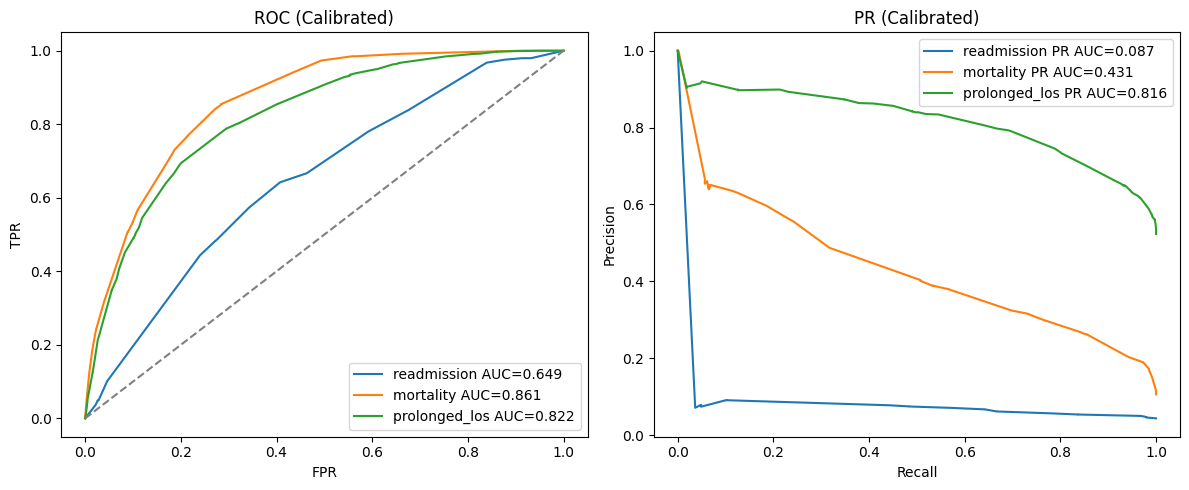

In [13]:
# ROC & PR curves (calibrated) for all targets
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc
from joblib import load as jobload

roc_data = {}
pr_data = {}
for tgt_name, label_col in TARGET_SPECS:
    model_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (model_path.exists() and iso_path.exists()):
        print('Missing artifacts for', tgt_name)
        continue
    model = jobload(model_path)
    iso = jobload(iso_path)
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    raw = model.predict_proba(X_te)[:,1]
    cal = iso.transform(raw)
    fpr,tpr,_ = roc_curve(y_te_t, cal)
    prec,rec,_ = precision_recall_curve(y_te_t, cal)
    roc_auc = sk_auc(fpr,tpr)
    pr_auc = sk_auc(rec,prec)
    roc_data[tgt_name] = (fpr,tpr,roc_auc)
    pr_data[tgt_name] = (rec,prec,pr_auc)

fig, axes = plt.subplots(1,2, figsize=(12,5))
for tgt,(fpr,tpr,roc_auc) in roc_data.items():
    axes[0].plot(fpr,tpr,label=f"{tgt} AUC={roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--',color='grey'); axes[0].set_title('ROC (Calibrated)'); axes[0].legend(); axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
for tgt,(rec,prec,pr_auc) in pr_data.items():
    axes[1].plot(rec,prec,label=f"{tgt} PR AUC={pr_auc:.3f}")
axes[1].set_title('PR (Calibrated)'); axes[1].legend(); axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision')
plt.tight_layout(); plt.show()

## 10. Feature Importance
Plot model-specific or permutation-based importance for audit.

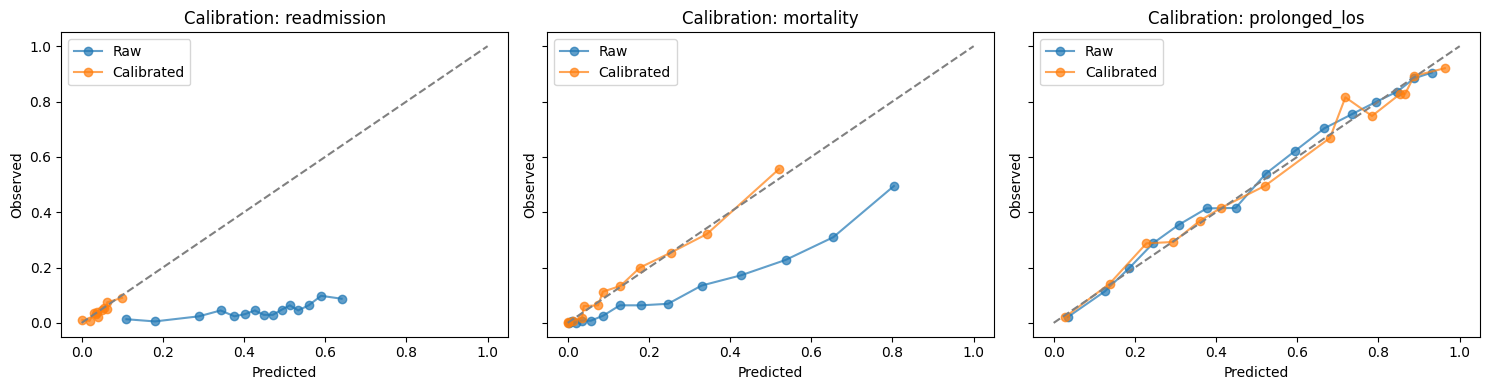

readmission: mean |raw-cal| = 0.38196
mortality: mean |raw-cal| = 0.13024
prolonged_los: mean |raw-cal| = 0.02678


In [14]:
# Calibration curves for all targets (using shared_inference unified loading)
from project.shared_inference import get_model_and_calibrator, apply_calibration, _resolve_models_dir
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import numpy as np

ARTIFACTS_DIR = _resolve_models_dir()

calibration_targets = []  # (tgt_name, y_true_test, raw_probs, calibrated_probs)
for tgt_name, label_col in TARGET_SPECS:
    try:
        model, calibrator = get_model_and_calibrator(tgt_name, models_dir=ARTIFACTS_DIR)
    except FileNotFoundError:
        print('Skip (missing artifacts):', tgt_name)
        continue
    y_all = labels_df[label_col].astype(int).to_numpy(); y_te_t = y_all[idx_te]
    raw = model.predict_proba(X_te)[:,1]
    cal = apply_calibration(raw, calibrator)
    calibration_targets.append((tgt_name, y_te_t, raw, cal))

if not calibration_targets:
    raise RuntimeError('No targets available for calibration plotting.')

fig, axes = plt.subplots(1, len(calibration_targets), figsize=(5*len(calibration_targets),4), sharey=True)
if len(calibration_targets) == 1:
    axes = [axes]

for ax,(tgt,y_true,raw,cal) in zip(axes, calibration_targets):
    fr_raw, mp_raw = calibration_curve(y_true, raw, n_bins=15, strategy='quantile')
    fr_cal, mp_cal = calibration_curve(y_true, cal, n_bins=15, strategy='quantile')
    ax.plot(mp_raw, fr_raw, 'o-', label='Raw', alpha=0.7)
    ax.plot(mp_cal, fr_cal, 'o-', label='Calibrated', alpha=0.7)
    ax.plot([0,1],[0,1], '--', color='gray')
    ax.set_title(f'Calibration: {tgt}')
    ax.set_xlabel('Predicted'); ax.set_ylabel('Observed')
    ax.legend()
plt.tight_layout(); plt.show()

# Report average absolute calibration shift per target
for tgt, y_true, raw, cal in calibration_targets:
    shift = float(np.mean(np.abs(raw - cal)))
    print(f"{tgt}: mean |raw-cal| = {shift:.5f}")

## 11. Distribution Checks
Visualize probability distributions by outcome class.

In [15]:
# Manual isotonic calibration (sklearn XGBClassifier base, no DMatrix)
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression
import numpy as np

# Base model: train-only (exclude validation for calibration fairness)
params = study.best_params.copy()
base_model = XGBClassifier(
    objective='binary:logistic', tree_method='hist',
    learning_rate=params['learning_rate'],
    n_estimators=params['n_estimators'],
    max_depth=params['max_depth'],
    min_child_weight=params['min_child_weight'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    reg_lambda=params['lambda'],
    reg_alpha=params['alpha'],
    gamma=params['gamma'],
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    verbosity=0
)
base_model.fit(X_tr, y_tr)
val_proba_raw = base_model.predict_proba(X_val)[:,1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_proba_raw, y_val)
print('Isotonic calibration fitted on validation set.')

def predict_calibrated(X):
    return iso.transform(base_model.predict_proba(X)[:,1])

# Derive operating threshold on calibrated validation probabilities
val_cal = predict_calibrated(X_val)
ths = np.linspace(0.01,0.9,300)
threshold_info = None
for t in ths:
    m = metrics_at(val_cal, y_val, t)
    if (threshold_info is None) or (m['f1'] > threshold_info['f1']):
        threshold_info = {**m, 'threshold': float(t)}
print('Selected threshold (calibrated validation):', threshold_info)

Isotonic calibration fitted on validation set.
Selected threshold (calibrated validation): {'f1': 0.1191672648959081, 'precision': np.float64(0.07242582897026839), 'recall': np.float64(0.33603238866260715), 'cost': np.float64(1883.0), 'fbeta': np.float64(0.19447047766439005), 'threshold': 0.05762541806020067}
Selected threshold (calibrated validation): {'f1': 0.1191672648959081, 'precision': np.float64(0.07242582897026839), 'recall': np.float64(0.33603238866260715), 'cost': np.float64(1883.0), 'fbeta': np.float64(0.19447047766439005), 'threshold': 0.05762541806020067}


## 12. Artifact Persistence
Save models, feature columns, provenance, (optional) calibrators.

In [16]:
# Unified summary table: tuned vs baseline metrics per target
import json, pandas as pd
rows = []
for tgt_name, _ in TARGET_SPECS:
    metrics_path = ARTIFACTS_DIR / f'metrics_{tgt_name}.json'
    if not metrics_path.exists():
        continue
    with open(metrics_path) as f:
        m = json.load(f)
    rows.append({
        'target': tgt_name,
        'auc': m['auc'],
        'pr_auc': m['pr_auc'],
        'brier': m['brier'],
        'threshold': m['threshold'],
        'f1_at_threshold': m['f1_at_threshold'],
        'precision_at_threshold': m['precision_at_threshold'],
        'recall_at_threshold': m['recall_at_threshold'],
        'baseline_val_auc': baseline_results.get(tgt_name)
    })
summary_df = pd.DataFrame(rows)
print(summary_df.sort_values('target'))
summary_df.to_csv(ARTIFACTS_DIR / 'metrics_summary.csv', index=False)
print('Wrote metrics_summary.csv')

          target       auc    pr_auc     brier  threshold  f1_at_threshold  precision_at_threshold  recall_at_threshold  baseline_val_auc
1      mortality  0.861058  0.400824  0.074992   0.206455         0.449754                0.388350             0.534224          0.792318
2  prolonged_los  0.821765  0.806928  0.171392   0.361237         0.769792                0.700498             0.854300          0.802140
0    readmission  0.649249  0.067601  0.041148   0.054649         0.128788                0.074282             0.483740          0.587455
Wrote metrics_summary.csv


In [17]:
# Compare full (train+val) vs base calibrated models on test
from joblib import load as jobload
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

comparison_rows = []
missing_any = False
for tgt_name, label_col in TARGET_SPECS:
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    full_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (full_path.exists() and base_path.exists() and iso_path.exists()):
        print('Skipping', tgt_name, 'missing one of required artifacts')
        missing_any = True
        continue
    full_model = jobload(full_path)
    base_model = jobload(base_path)
    iso = jobload(iso_path)
    raw_full = full_model.predict_proba(X_te)[:,1]
    raw_base = base_model.predict_proba(X_te)[:,1]
    cal_base = iso.transform(raw_base)
    row = {
        'target': tgt_name,
        'full_raw_auc': roc_auc_score(y_te_t, raw_full),
        'full_raw_pr_auc': average_precision_score(y_te_t, raw_full),
        'base_raw_auc': roc_auc_score(y_te_t, raw_base),
        'base_cal_auc': roc_auc_score(y_te_t, cal_base),
        'base_cal_pr_auc': average_precision_score(y_te_t, cal_base),
        'base_cal_brier': brier_score_loss(y_te_t, cal_base)
    }
    comparison_rows.append(row)

comparison_df = pd.DataFrame(comparison_rows)
if len(comparison_df):
    display(comparison_df.sort_values('target'))
    comparison_df.to_csv(ARTIFACTS_DIR / 'full_vs_calibrated_comparison.csv', index=False)
    print('Wrote full_vs_calibrated_comparison.csv')
else:
    print('No comparison rows generated.')

,target,full_raw_auc,full_raw_pr_auc,base_raw_auc,base_cal_auc,base_cal_pr_auc,base_cal_brier
1,mortality,0.864259,0.428864,0.862605,0.861058,0.400824,0.074992
2,prolonged_los,0.824782,0.819913,0.822717,0.821765,0.806928,0.171392
0,readmission,0.658868,0.072560,0.652448,0.649249,0.067601,0.041148


Wrote full_vs_calibrated_comparison.csv


## 13. Inference Preview
Load artifacts and score a small sample for sanity.

In [18]:
# Merge comparison with metrics summary (enriched)
import pandas as pd, json
summary_path = ARTIFACTS_DIR / 'metrics_summary.csv'
comp_path = ARTIFACTS_DIR / 'full_vs_calibrated_comparison.csv'
if summary_path.exists() and comp_path.exists():
    summary_df = pd.read_csv(summary_path)
    comp_df = pd.read_csv(comp_path)
    merged = summary_df.merge(comp_df, on='target', how='left')
    merged.to_csv(ARTIFACTS_DIR / 'metrics_summary_enriched.csv', index=False)
    print('Wrote metrics_summary_enriched.csv')
    display(merged.sort_values('target'))
else:
    print('Missing one of summary or comparison CSV; skip enrichment.')

Wrote metrics_summary_enriched.csv


,target,auc,pr_auc,brier,threshold,f1_at_threshold,precision_at_threshold,recall_at_threshold,baseline_val_auc,full_raw_auc,full_raw_pr_auc,base_raw_auc,base_cal_auc,base_cal_pr_auc,base_cal_brier
1,mortality,0.861058,0.400824,0.074992,0.206455,0.449754,0.388350,0.534224,0.792318,0.864259,0.428864,0.862605,0.861058,0.400824,0.074992
2,prolonged_los,0.821765,0.806928,0.171392,0.361237,0.769792,0.700498,0.854300,0.802140,0.824782,0.819913,0.822717,0.821765,0.806928,0.171392
0,readmission,0.649249,0.067601,0.041148,0.054649,0.128788,0.074282,0.483740,0.587455,0.658868,0.072560,0.652448,0.649249,0.067601,0.041148


In [19]:
# AUC Difference Significance (Bootstrap between full_raw and base_cal)
import numpy as np, pandas as pd
from joblib import load as jobload
from sklearn.metrics import roc_auc_score

RESULTS = []
N_BOOT = 2000  # increase for tighter CI (runtime ~ O(N_BOOT))
RNG = np.random.default_rng(42)

for tgt_name, label_col in TARGET_SPECS:
    full_path = ARTIFACTS_DIR / f'model_full_{tgt_name}.joblib'
    base_path = ARTIFACTS_DIR / f'model_{tgt_name}.joblib'
    iso_path = ARTIFACTS_DIR / f'isotonic_{tgt_name}.joblib'
    if not (full_path.exists() and base_path.exists() and iso_path.exists()):
        print('Skip significance for', tgt_name, '(missing artifacts)')
        continue
    y_all = labels_df[label_col].astype(int).to_numpy()
    y_te_t = y_all[idx_te]
    full_model = jobload(full_path)
    base_model = jobload(base_path)
    iso = jobload(iso_path)
    raw_full = full_model.predict_proba(X_te)[:,1]
    cal_base = iso.transform(base_model.predict_proba(X_te)[:,1])
    auc_full = roc_auc_score(y_te_t, raw_full)
    auc_cal = roc_auc_score(y_te_t, cal_base)
    diff = auc_full - auc_cal
    n = len(y_te_t)
    # Bootstrap
    diffs = np.empty(N_BOOT)
    for b in range(N_BOOT):
        idx = RNG.integers(0, n, size=n)
        y_b = y_te_t[idx]
        rf_b = raw_full[idx]
        cb_b = cal_base[idx]
        try:
            diffs[b] = roc_auc_score(y_b, rf_b) - roc_auc_score(y_b, cb_b)
        except ValueError:
            # In rare case bootstrap sample has only one class
            diffs[b] = np.nan
    diffs = diffs[~np.isnan(diffs)]
    if len(diffs) < N_BOOT * 0.9:
        print('Warning: many degenerate bootstrap samples for', tgt_name)
    lower, upper = np.percentile(diffs, [2.5, 97.5])
    # Two-sided p-value: proportion of bootstrap diffs with opposite sign or more extreme
    if diff >= 0:
        p = (np.sum(diffs <= 0) + 1) / (len(diffs) + 1)
    else:
        p = (np.sum(diffs >= 0) + 1) / (len(diffs) + 1)
    RESULTS.append({
        'target': tgt_name,
        'auc_full_raw': auc_full,
        'auc_base_cal': auc_cal,
        'diff_full_minus_cal': diff,
        'ci_95_lower': lower,
        'ci_95_upper': upper,
        'approx_p_two_sided': p * 2 if p * 2 <= 1 else 1.0,
        'n_test': n,
        'n_boot_effective': int(len(diffs))
    })

if RESULTS:
    sig_df = pd.DataFrame(RESULTS).sort_values('target')
    display(sig_df)
    sig_df.to_csv(ARTIFACTS_DIR / 'auc_diff_significance.csv', index=False)
    print('Wrote auc_diff_significance.csv')
else:
    print('No targets processed for significance analysis.')

,target,auc_full_raw,auc_base_cal,diff_full_minus_cal,ci_95_lower,ci_95_upper,approx_p_two_sided,n_test,n_boot_effective
1,mortality,0.864259,0.861058,0.003201,-0.001591,0.007945,0.191904,5668,2000
2,prolonged_los,0.824782,0.821765,0.003017,0.000643,0.005415,0.013993,5668,2000
0,readmission,0.658868,0.649249,0.009619,-0.007953,0.026638,0.269865,5668,2000


Wrote auc_diff_significance.csv


## 14. Next Steps
- Run on larger cohort
- Perform temporal validation
- Package pipeline for scheduled runs